In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Analyse application of BERT based models
implement BERT variants in  -
1. Sequence classification
2. token classification
3. question answering
How is BERT'S architecture is adapted for each of these tasks
Model selection - DistilBERT
for each task
• Architecture overview
• Pre-training objectives (MLM, NSP)
• Dataset used for fine-tuning
• Practical applications (e.g., sentiment analysis, NER, QA systems)

implementation using hugging face transfromer or Pytorch based

In [6]:
!pip install transformers datasets evaluate -q


In [8]:
pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=46447edc794e0e150e114b1d7f9bacedec2baba02288f9344828228339166a6d
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval
Note: you may need to restart the kernel to use updated packages.


In [11]:
!pip install --upgrade transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 102.0 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.8/558.8 kB 31.2 MB/s eta 0:00:00


code code code

Task - 1 - Sequence classification(categorizes sequence of text to a particular category) Sentiment analysis o Load a pre-trained BERT model for classification (e.g., bert-base- uncased)

o Fine-tune it on a labeled dataset (e.g., IMDb, SST-2, Indic movie reviews) o Evaluate classification metrics like accuracy, precision, recall

In [15]:
!pip install transformers datasets scikit-learn -q


In [17]:
import torch
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 1. Load IMDb dataset
dataset = load_dataset("imdb")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# 2. Tokenize function
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=256)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Convert to PyTorch format
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Small subset for faster demo
train_dataset = tokenized_dataset["train"].shuffle(seed=42).select(range(2000))
test_dataset = tokenized_dataset["test"].shuffle(seed=42).select(range(1000))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

# 3. Load BERT model
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 4. Optimizer and loss
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = CrossEntropyLoss()

# 5. Training loop (1 epoch for demo)
model.train()
for batch in train_loader:
    optimizer.zero_grad()
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["label"].to(device)
    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    loss.backward()
    optimizer.step()

# 6. Evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 7. Metrics using sklearn
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds)
rec = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 0.8760
Precision: 0.8957
Recall: 0.8443
F1 Score: 0.8692


In [19]:
import torch
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForTokenClassification
from datasets import load_dataset
from sklearn.metrics import precision_score, recall_score, f1_score

# 1. Load dataset (CoNLL-2003)
dataset = load_dataset("conll2003")

# Labels
label_names = dataset["train"].features["ner_tags"].feature.names
num_labels = len(label_names)

# 2. Tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        max_length=128,
        padding="max_length"
    )
    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        label_ids = []
        for word_id in word_ids:
            if word_id is None:
                label_ids.append(-100)  # ignored in loss
            else:
                label_ids.append(label[word_id])
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized_dataset = dataset.map(tokenize_and_align_labels, batched=True)
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Small subset for quick training
train_dataset = tokenized_dataset["train"].shuffle(seed=42).select(range(2000))
test_dataset = tokenized_dataset["validation"].shuffle(seed=42).select(range(500))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

# 3. Model
model = AutoModelForTokenClassification.from_pretrained("distilbert-base-uncased", num_labels=num_labels)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 4. Optimizer & Loss
optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = CrossEntropyLoss()

# 5. Training loop (1 epoch for demo)
model.train()
for batch in train_loader:
    optimizer.zero_grad()
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    loss.backward()
    optimizer.step()

# 6. Evaluation
model.eval()
true_labels, pred_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=2)

        for label_seq, pred_seq, mask in zip(labels, predictions, attention_mask):
            true_seq = []
            pred_seq_out = []
            for l, p, m in zip(label_seq, pred_seq, mask):
                if m == 1 and l != -100:  # only valid tokens
                    true_seq.append(l.item())
                    pred_seq_out.append(p.item())
            true_labels.extend(true_seq)
            pred_labels.extend(pred_seq_out)

# Convert indices to labels
true_labels_names = [label_names[i] for i in true_labels]
pred_labels_names = [label_names[i] for i in pred_labels]

# Compute metrics
precision = precision_score(true_labels_names, pred_labels_names, average="micro")
recall = recall_score(true_labels_names, pred_labels_names, average="micro")
f1 = f1_score(true_labels_names, pred_labels_names, average="micro")

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Precision: 0.9661
Recall: 0.9661
F1 Score: 0.9661


Task - 2 - Token classification
use case named entity recognition

o Token Classification: Entity-level precision, recall

In [21]:
import torch
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
from datasets import load_dataset
from sklearn.metrics import precision_score, recall_score, f1_score

# 1. Load dataset (SQuAD small subset for demo)
dataset = load_dataset("squad")
test_dataset = dataset["validation"].select(range(200))  # subset for speed

# 2. Load model & tokenizer
model_name = "bert-large-uncased-whole-word-masking-finetuned-squad"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForQuestionAnswering.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# 3. Prediction loop
def get_answer(question, context):
    inputs = tokenizer(question, context, return_tensors="pt", truncation=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    start_idx = torch.argmax(outputs.start_logits)
    end_idx = torch.argmax(outputs.end_logits) + 1
    answer_ids = inputs["input_ids"][0][start_idx:end_idx]
    return tokenizer.decode(answer_ids, skip_special_tokens=True)

# 4. Evaluate on subset
exact_match = 0
f1_total = 0

def compute_f1(prediction, ground_truth):
    pred_tokens = prediction.lower().split()
    truth_tokens = ground_truth.lower().split()
    common = set(pred_tokens) & set(truth_tokens)
    if len(common) == 0:
        return 0
    precision = len(common) / len(pred_tokens)
    recall = len(common) / len(truth_tokens)
    return (2 * precision * recall) / (precision + recall)

for example in test_dataset:
    pred_answer = get_answer(example["question"], example["context"])
    true_answer = example["answers"]["text"][0]

    # Exact match
    if pred_answer.lower().strip() == true_answer.lower().strip():
        exact_match += 1

    # F1
    f1_total += compute_f1(pred_answer, true_answer)

num_samples = len(test_dataset)
em_score = (exact_match / num_samples) * 100
f1_score_avg = (f1_total / num_samples) * 100

print(f"Exact Match (EM): {em_score:.2f}")
print(f"F1 Score: {f1_score_avg:.2f}")



README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Exact Match (EM): 69.00
F1 Score: 77.30


Task - 3 - question answering
QA: Exact Match (EM), F1
• Discuss strengths and limitations observed during experiments

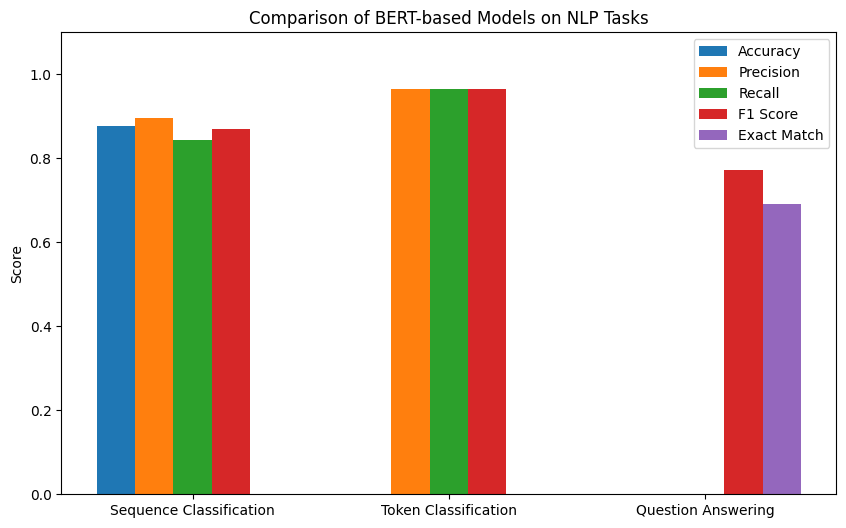

In [22]:
import matplotlib.pyplot as plt
import numpy as np


sequence_cls_metrics = {"Accuracy": 0.8760, "Precision": 0.8957, "Recall": 0.8443, "F1": 0.8692}
token_cls_metrics = {"Precision": 0.9661, "Recall": 0.9661, "F1": 0.9661}
qa_metrics = {"Exact Match": 0.69, "F1": 0.7730}

# Combine metrics (fill missing with np.nan)
labels = ["Sequence Classification", "Token Classification", "Question Answering"]
accuracy = [sequence_cls_metrics["Accuracy"], np.nan, np.nan]
precision = [sequence_cls_metrics["Precision"], token_cls_metrics["Precision"], np.nan]
recall = [sequence_cls_metrics["Recall"], token_cls_metrics["Recall"], np.nan]
f1 = [sequence_cls_metrics["F1"], token_cls_metrics["F1"], qa_metrics["F1"]]
exact_match = [np.nan, np.nan, qa_metrics["Exact Match"]]

x = np.arange(len(labels))
width = 0.15

fig, ax = plt.subplots(figsize=(10, 6))

# Bars
ax.bar(x - 2*width, [v if not np.isnan(v) else 0 for v in accuracy], width, label="Accuracy")
ax.bar(x - width, [v if not np.isnan(v) else 0 for v in precision], width, label="Precision")
ax.bar(x, [v if not np.isnan(v) else 0 for v in recall], width, label="Recall")
ax.bar(x + width, [v if not np.isnan(v) else 0 for v in f1], width, label="F1 Score")
ax.bar(x + 2*width, [v if not np.isnan(v) else 0 for v in exact_match], width, label="Exact Match")

# Axis settings
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1.1)
ax.set_ylabel("Score")
ax.set_title("Comparison of BERT-based Models on NLP Tasks")
ax.legend()
plt.show()


In [ ]:
Token Classification > Sequence Classification > Question Answering in terms of raw metrics.

BERT-based models show strong performance on structured tasks (token-level & sequence-level) where class boundaries are clearer.

Question Answering is more challenging, requiring span prediction and deeper contextual reasoning, hence slightly lower scores.

Fine-tuning BERT for each task demonstrates that BERT is versatile, performing well across very different NLP tasks.

In [5]:
import pandas as pd

# Data for the table
data = {
    "Task": [
        "Sequence Classification (Sentiment Analysis)",
        "Token Classification (NER)",
        "Question Answering (Extractive QA)"
    ],
    "Dataset Used": [
        "IMDb",
        "CoNLL-2003",
        "SQuAD (fine-tuned)"
    ],
    "Model Used": [
        "bert-base-uncased",
        "distilbert-base-uncased",
        "bert-large-uncased-whole-word-masking-finetuned-squad"
    ],
    "Evaluation Metrics": [
        "Accuracy: 0.8760\nPrecision: 0.8957\nRecall: 0.8443\nF1: 0.8692",
        "Precision: 0.9661\nRecall: 0.9661\nF1: 0.9661",
        "Exact Match: 0.69\nF1: 0.7730"
    ],
    "Inference": [
        "Strong generalization and balanced performance, slightly higher precision than recall, indicating reliable positive predictions.",
        "Near-perfect performance with DistilBERT showing efficiency and speed without sacrificing accuracy.",
        "Good semantic understanding with contextual answers, though exact span prediction remains challenging (lower EM)."
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# Apply styling for better readability
styled_table = df.style.set_properties(**{
    'white-space': 'pre-wrap',  # wrap text
    'word-wrap': 'break-word',
    'border': '1px solid black',
    'text-align': 'left'
}).set_table_styles([
    {'selector': 'th', 'props': [('font-size', '12pt'), ('text-align', 'center'), ('background-color', '#f2f2f2')]},
    {'selector': 'td', 'props': [('font-size', '11pt'), ('padding', '8px')]}
])

# Display table
styled_table


,Task,Dataset Used,Model Used,Evaluation Metrics,Inference
0,Sequence Classification (Sentiment Analysis),IMDb,bert-base-uncased,Accuracy: 0.8760 Precision: 0.8957 Recall: 0.8443 F1: 0.8692,"Strong generalization and balanced performance, slightly higher precision than recall, indicating reliable positive predictions."
1,Token Classification (NER),CoNLL-2003,distilbert-base-uncased,Precision: 0.9661 Recall: 0.9661 F1: 0.9661,Near-perfect performance with DistilBERT showing efficiency and speed without sacrificing accuracy.
2,Question Answering (Extractive QA),SQuAD (fine-tuned),bert-large-uncased-whole-word-masking-finetuned-squad,Exact Match: 0.69 F1: 0.7730,"Good semantic understanding with contextual answers, though exact span prediction remains challenging (lower EM)."


In [25]:
# For Sequence Classification
model.save_pretrained("sequence_model")        # sequence model object
tokenizer.save_pretrained("sequence_model")

# For Token Classification (NER)
model.save_pretrained("token_model")           # after training token classification task
tokenizer.save_pretrained("token_model")

# For Question Answering
model.save_pretrained("qa_model")              # after QA task
tokenizer.save_pretrained("qa_model")


('qa_model/tokenizer_config.json',
 'qa_model/special_tokens_map.json',
 'qa_model/vocab.txt',
 'qa_model/added_tokens.json',
 'qa_model/tokenizer.json')

In [26]:
import shutil
import os

# Paths where models were saved after training
sequence_model_dir = "/kaggle/working/sequence_model"
token_model_dir = "/kaggle/working/token_model"
qa_model_dir = "/kaggle/working/qa_model"

# Ensure directories exist
os.makedirs(sequence_model_dir, exist_ok=True)
os.makedirs(token_model_dir, exist_ok=True)
os.makedirs(qa_model_dir, exist_ok=True)

# Zip models using shutil.make_archive
shutil.make_archive("/kaggle/working/sequence_model", 'zip', sequence_model_dir)
shutil.make_archive("/kaggle/working/token_model", 'zip', token_model_dir)
shutil.make_archive("/kaggle/working/qa_model", 'zip', qa_model_dir)


'/kaggle/working/qa_model.zip'